# EEG to Image Generation
Robert Sato, Alexander Cardaras
<br>UC Santa Cruz
## Version Info
### Updated: 5/12/21

## Issues:

## General Notes

## Revisions


# Directions:
- **Execute** mount drive cell
- **Skip** load, convert and save data to Numpy files section
- **Execute** cells starting from **Classify the EEG wave data section**

**Mount drive**

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
# Colab Pro GPUs
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri May 14 18:58:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Colab Pro More RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# Load, convert and save data to Numpy files
- only executed once to generate .npy files
- load the .npy files directly for future use

In [ ]:
import torch
import numpy as np
from numpy import save
from numpy import load

In [ ]:
# use the default data_path
# eeg_55_95_std.pth - saved
# eeg_14_70_std.pth - saved
# eeg_5_95_std.pth - saved

raw_data_path = "/content/gdrive/MyDrive/EEG2Image/eeg_55_95_std.pth"
save_data_path = "/content/gdrive/MyDrive/EEG2Image/data/"

In [ ]:
# load eeg data from .pth files
loaded = torch.load(raw_data_path)
data = loaded['dataset']        
labels = loaded["labels"]
images = loaded["images"]
size = len(data)
print(size)

KeyboardInterrupt: ignored

In [ ]:
# convert data tensors to np
eeg_data = []
labels = []

# crop the first 20ms and last 40ms out
time_low = 20
time_high = 460

verbose = False # set to True to print information on the data

for i in range(size):
    if verbose:
        data_i = data[i]
        print("Keys stored in each data[i] object:", data_i.keys())

        eeg_i = data[i]["eeg"]
        print("Shape of data[i][\"eeg\"]:", eeg_i.shape)
        print("Type of data[i][\"eeg\"]:", eeg_i.type)
        print()

        eeg_f = data[i]["eeg"].float() # simply converts to float
        print("Shape of data[i][\"eeg\"].float():", eeg_f.shape)
        print("Type of data[i][\"eeg\"].float():", eeg_f.type)
        print()

        eeg_t = data[i]["eeg"].float().t() # transposes the matrix
        print("Shape of data[i][\"eeg\"].float().t():", eeg_t.shape)
        print("Type of data[i][\"eeg\"].float().t():", eeg_t.type)
        print()

        image = data[i]["image"]
        print("image:", image)

        label = data[i]["label"]
        print("label:", label)

        subject = data[i]["subject"]
        print("subject:", subject)

    eeg = data[i]["eeg"].float().t()
    eeg = eeg[time_low:time_high,:] # trim the data to between 0.2s - 0.46s
    label = data[i]["label"]

    # convert from tensor to numpy
    eeg_data.append(eeg.numpy())
    labels.append(label)

eeg_data = np.asarray(eeg_data)
labels = np.asarray(labels)
print("Shape of EEG data:", eeg_data.shape)
print("Shape of labels:", labels.shape)

### Information about the .pth file data
- 6 subjects
- 40 image classes
- 50 images per class

6 subjects * 40 classes * 50 images/class = 12,000 segments
- each image (segment) = .5 ms @ 1kHz = 500 samples during the segment
- each sample = 128 channels

each segment = 128 * 500 voltage values

In [ ]:
save("/content/gdrive/MyDrive/EEG2Image/data/eeg_55_95.npy", eeg_data)
save("/content/gdrive/MyDrive/EEG2Image/data/labels_55_95.npy", labels)

In [ ]:
eeg_data = load("/content/gdrive/MyDrive/EEG2Image/data/eeg_55_95.npy")
labels = load("/content/gdrive/MyDrive/EEG2Image/data/labels_55_95.npy")

In [ ]:
print(eeg_data.shape)

# Classify the EEG wave data
- load the data
- build a model
- train the model
- evaluate
- predict

In [4]:
import numpy as np
from numpy import save, load
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l1, l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

### Load the data

In [5]:
# options for data separated by frequency bands
# eeg_55_95.npy
# eeg_14_70.npy
# eeg_5_95.npy

print("Input which subset of data to use. Normalized sigmoid 55-95Hz (0), 14-70Hz (1), 55-95Hz (2), 5-95Hz (3), norm linear 55-95Hz(_)")
x = input()
x = int(x)

labels = load("/content/gdrive/MyDrive/EEG2Image/data/labels_5_95.npy")
if x == 0:
    data = load("/content/gdrive/MyDrive/EEG2Image/data/eeg_norm_sigmoid_55_95.npy")
    print("Finished loading sigmoid normalized 55-95Hz data")
elif x == 1:
    data = load("/content/gdrive/MyDrive/EEG2Image/data/eeg_14_70.npy")
    print("Finished loading 14-70Hz data")
elif x == 2:
    data = load("/content/gdrive/MyDrive/EEG2Image/data/eeg_55_95.npy")
    print("Finished loading 55-95Hz data")
elif x == 3:
    data = load("/content/gdrive/MyDrive/EEG2Image/data/eeg_5_95.npy")
    print("Finished loading 5-95Hz data")
else:
    data = load("/content/gdrive/MyDrive/EEG2Image/data/eeg_norm_linear_55_95.npy")
    print("Finished loading linear normalized 55-95Hz data")

Input which subset of data to use. Normalized sigmoid 55-95Hz (0), 14-70Hz (1), 55-95Hz (2), 5-95Hz (3), norm linear 55-95Hz(_)
2
Finished loading 55-95Hz data


In [6]:
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
print(labels[:100])

Data shape: (11965, 440, 128)
Labels shape: (11965,)
[10 30 29 10 30 25 18 30  3  8 11 18 28 38 37 20  3 28 23  0 38 34 20 23
 39  0 17 34 11 21 20 10 37 39  7  6 26 20  1 27 30 35 37 19  9 12 18 25
 27  4 13 34 35 25  8 29 15 12 17 38 37 27 25 32 22  2 35 14  5  8 20 31
 25 31 37  2 33  6 37 32  5 26 26 20 30 34 18 23 18  2  3 19 11 26 20 27
 27 18 39 33]


### Restrict data to < 40 classes?

In [7]:
# restrict data to first num_classes classes
def restrict_data(data, labels, num_classes=10):
    data_10 = []
    labels_10 = []

    for i in range(len(labels)):
        if labels[i] < num_classes:
            data_10.append(data[i])
            labels_10.append(labels[i])

    data_10 = np.asarray(data_10)
    labels_10 = np.asarray(labels_10)

    print("Reshaped data:", data_10.shape)
    print("Reshaped labels:", labels_10.shape)

    return data_10, labels_10

In [8]:
data, labels = restrict_data(data, labels, num_classes=5)

Reshaped data: (1500, 440, 128)
Reshaped labels: (1500,)


In [9]:
print(labels[:100])

[3 3 0 0 1 4 2 2 2 3 1 1 2 4 3 3 0 4 0 4 3 0 3 1 1 3 1 3 4 4 3 3 3 3 4 1 1
 1 1 1 3 3 1 3 1 1 0 3 3 1 1 2 1 0 2 0 4 2 2 4 2 0 0 4 0 0 1 4 4 1 1 2 3 4
 1 2 4 1 3 2 3 3 4 0 0 2 2 1 3 1 4 2 2 0 0 4 2 1 1 0]


## Normalize the data (if not already normalized)

### Mean 0, sigmoid

In [ ]:
# transpose the data to channels on the first axis to normalize
data = data.transpose(2, 0, 1)
print("Data shape:", data.shape)

Data shape: (128, 11965, 440)


In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# vectorie the function so it can be applied to np arrays
sigmoid_v = np.vectorize(sigmoid)

In [ ]:
def normalize_array(data):
    # compute the average
    avg = np.average(data)
    print("Average EEG reading:", avg)
    print("data[0][0] (before shifting):", data[0][0])
    # center the data around 0 by subtracting the average
    shifted = data - avg
    print("Shape of shifted data:", shifted.shape)
    print("shifted[0][0] (after shifting):", shifted[0][0])
    # apply sigmoid function to get values in the range 0 - 1
    return sigmoid_v(shifted)

def normalize_data(data):
    # expects array of arrays as input
    for i in range(len(data)):
        print("\nNormalizing channel", i)
        data[i] = normalize_array(data[i])

In [ ]:
normalize_data(data)

In [ ]:
# check normalization
print("min:", np.amin(data))
print("max:", np.amax(data))

min: 1.7935853e-31
max: 1.0


In [ ]:
# revert the data
data = data.transpose(1, 2, 0)
print("Data shape:", data.shape)

Data shape: (11965, 440, 128)


In [ ]:
save("/content/gdrive/MyDrive/EEG2Image/data/eeg_norm_sigmoid_55_95.npy", data)

In [ ]:
plt.figure(figsize=(20,20))
plt.plot(data[0])

### Linear Normalization - [min, max] -> [0, 1]

In [ ]:
# transpose the data to channels on the first axis to normalize
data = data.transpose(2, 0, 1)
print("Data shape:", data.shape)

Data shape: (128, 11965, 440)


In [ ]:
def normalize_data(data):
    # expects array of arrays as input
    for i in range(len(data)):
        min = np.amin(data[i])
        data[i] -= min
        # shift all values so min is 0
        # divide by new max
        max = np.amax(data[i])
        print("\nNormalizing channel", i, "\nMax:", max)
        data[i] /= max

In [ ]:
# check normalization
print("min:", np.amin(data))
print("max:", np.amax(data))

normalize_data(data)

print("After normalization:")
print("min:", np.amin(data))
print("max:", np.amax(data))

for channel in range(len(data)):
    print("Average EEG reading for channel i:", np.average(data[channel]))

min: -70.79585
max: 72.47691

Normalizing channel 0 
Max: 43.09008

Normalizing channel 1 
Max: 40.92071

Normalizing channel 2 
Max: 52.82456

Normalizing channel 3 
Max: 23.356005

Normalizing channel 4 
Max: 10.927322

Normalizing channel 5 
Max: 56.237

Normalizing channel 6 
Max: 67.69171

Normalizing channel 7 
Max: 35.436943

Normalizing channel 8 
Max: 43.188255

Normalizing channel 9 
Max: 17.634443

Normalizing channel 10 
Max: 34.000668

Normalizing channel 11 
Max: 16.651829

Normalizing channel 12 
Max: 25.444431

Normalizing channel 13 
Max: 12.618238

Normalizing channel 14 
Max: 55.49749

Normalizing channel 15 
Max: 51.34159

Normalizing channel 16 
Max: 14.752741

Normalizing channel 17 
Max: 14.113015

Normalizing channel 18 
Max: 16.144066

Normalizing channel 19 
Max: 24.502832

Normalizing channel 20 
Max: 15.731882

Normalizing channel 21 
Max: 17.543661

Normalizing channel 22 
Max: 13.646734

Normalizing channel 23 
Max: 13.906882

Normalizing channel 24 
Max: 

In [ ]:
# revert the data
data = data.transpose(1, 2, 0)
print("Data shape:", data.shape)

Data shape: (11965, 440, 128)


In [ ]:
save("/content/gdrive/MyDrive/EEG2Image/data/eeg_norm_linear_55_95.npy", data)

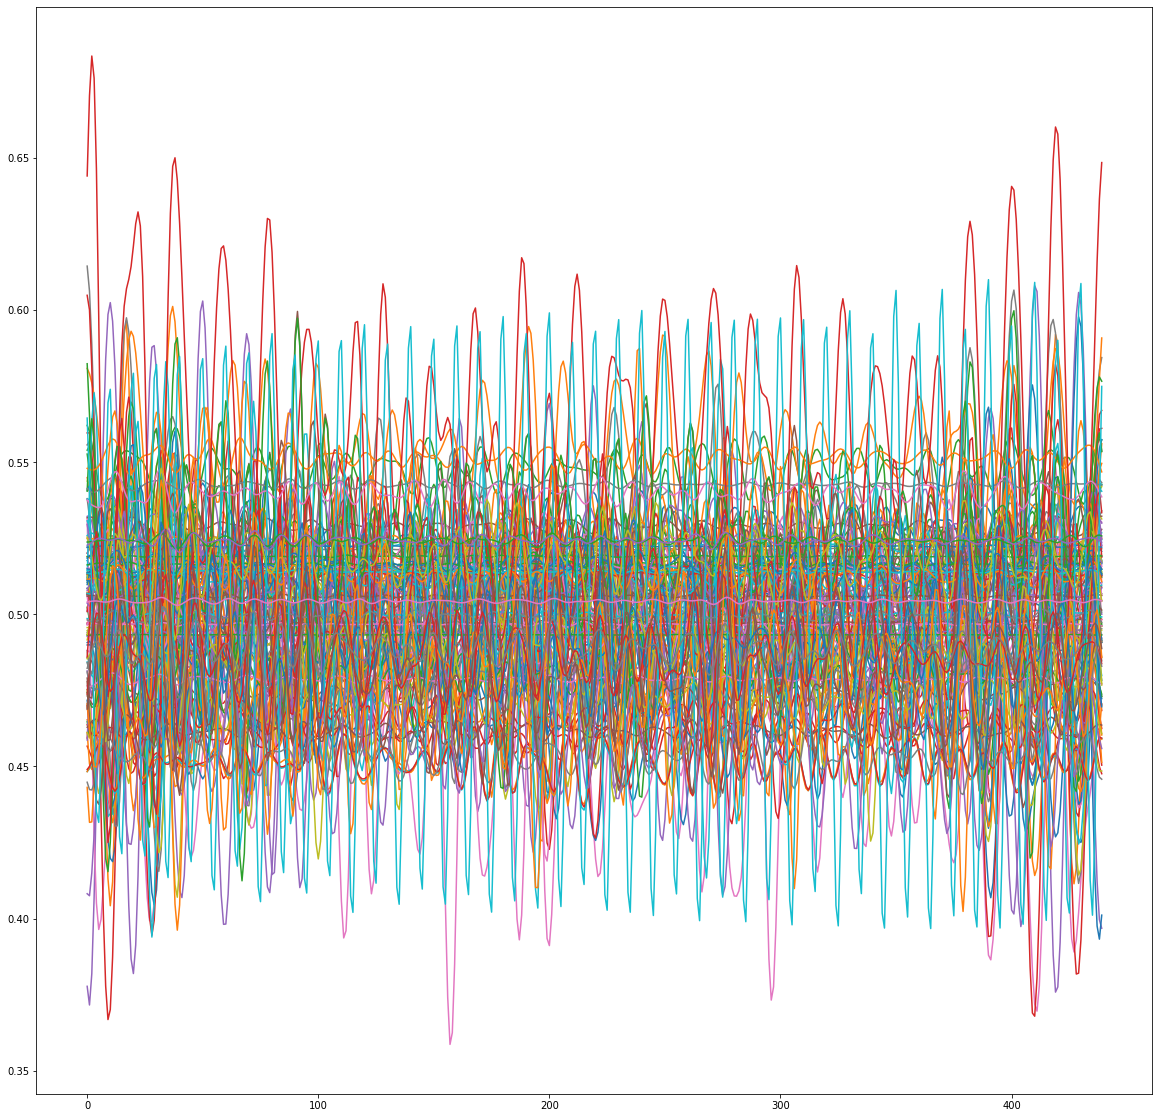

In [ ]:
plt.figure(figsize=(20,20))
plt.plot(data[0])

## EEG Classification

In [10]:
# initialize training and test data
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.20, random_state = 10)
print('Shape of x_train:', x_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of x_test:', x_test.shape)
print('Shape of y_test:', y_test.shape)

# one hot encode the labels
#y_train = to_categorical(y_train, 40)
#y_test = to_categorical(y_test, 40)

y_train = to_categorical(y_train, 40)
y_test = to_categorical(y_test, 40)

Shape of x_train: (1200, 440, 128)
Shape of y_train: (1200,)
Shape of x_test: (300, 440, 128)
Shape of y_test: (300,)


In [11]:
# define parameters
BATCH_SIZE = 16
EPOCHS = 100

TIMESTEPS = len(data[0])
TOTAL_INPUTS = len(data)
DATA_POINTS = TOTAL_INPUTS * TIMESTEPS 
FEATURES = len(x_train[0][0])

print('TIMESTEPS =', TIMESTEPS)
print('TOTAL_INPUTS =', TOTAL_INPUTS)
print('DATA_POINTS =', DATA_POINTS)
print('FEATURES =', FEATURES)

TIMESTEPS = 440
TOTAL_INPUTS = 1500
DATA_POINTS = 660000
FEATURES = 128


### LSTM Model

In [ ]:
# LSTM model
# reference: https://arxiv.org/pdf/1609.00344.pdf
model = Sequential()
model.add(LSTM(128, input_shape = (TIMESTEPS, FEATURES), activity_regularizer=l2(0.001))) 
model.add(Dense(128, activation='relu'))
model.add(Dense(40, activation='softmax'))

### CNN Model
This model is from the ThoughtViz paper
https://github.com/ptirupat/ThoughtViz/blob/24a4a8a7d3a3191bb0b45b7a2ba686ac7301875a/training/models/classification.py

In [12]:
# reshape the input for CNN to (_, 128, 440)
x_train = x_train.transpose(0, 2, 1)
x_test = x_test.transpose(0, 2, 1)

In [13]:
# reshape the input for CNN to (_, 128, 440, 1)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [14]:
# ThoughtViz paper:
# https://github.com/ptirupat/ThoughtViz/blob/24a4a8a7d3a3191bb0b45b7a2ba686ac7301875a/training/models/classification.py
print(x_train.shape)

# define the CNN model for classification
def convolutional_encoder_model(channels, observations, num_classes):
    model = Sequential()
    #model.add(BatchNormalization(input_shape=(channels, observations, 1)))
    model.add(BatchNormalization(input_shape=(channels, observations, 1) )) # dont specify batch size
    model.add(Conv2D(32, (1, 4), activation='relu'))
    model.add(Conv2D(25, (channels, 1), activation='relu'))
    model.add(MaxPooling2D((1, 3)))
    model.add(Conv2D(50, (4, 25), activation='relu', data_format='channels_first'))
    model.add(MaxPooling2D((1, 3)))
    model.add(Conv2D(100, (50, 2), activation='relu'))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))
    return model
model = convolutional_encoder_model(FEATURES, TIMESTEPS, num_classes=40)

(1200, 128, 440, 1)


### Model Summary, Fit and Results

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 128, 440, 1)       4         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 437, 32)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 437, 25)        102425    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 145, 25)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 142, 1)        5050      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 47, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 46, 100)        1

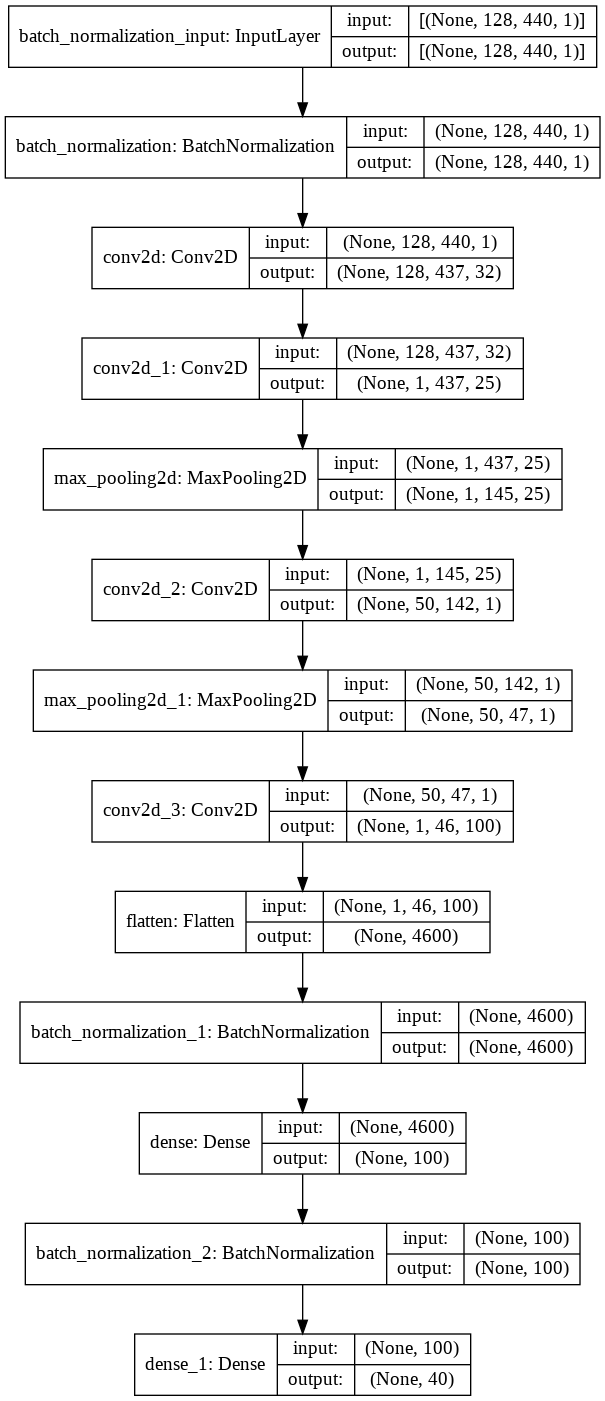

In [15]:
model.summary()
plot_model(model, to_file='classifier_model.png', show_shapes=True, show_layer_names=True)

In [18]:
# default schedule
#OPT = 'adam'
#OPT = 'SGD'
#ThoughtViz
OPT = tf.keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer = OPT, metrics = ['accuracy'])

In [19]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    #tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [20]:
history = model.fit(
    x_train, 
    y_train,
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=2,
    callbacks=my_callbacks)

Epoch 1/100
68/68 - 18s - loss: 3.4944 - accuracy: 0.1963 - val_loss: 3.6602 - val_accuracy: 0.2583
Epoch 2/100
68/68 - 1s - loss: 2.3333 - accuracy: 0.4870 - val_loss: 3.6055 - val_accuracy: 0.2833
Epoch 3/100
68/68 - 1s - loss: 1.5348 - accuracy: 0.6472 - val_loss: 3.4977 - val_accuracy: 0.3917
Epoch 4/100
68/68 - 1s - loss: 1.1495 - accuracy: 0.7259 - val_loss: 3.3122 - val_accuracy: 0.4167
Epoch 5/100
68/68 - 1s - loss: 0.8365 - accuracy: 0.7880 - val_loss: 3.0086 - val_accuracy: 0.5667
Epoch 6/100
68/68 - 1s - loss: 0.7461 - accuracy: 0.8093 - val_loss: 2.4983 - val_accuracy: 0.7000
Epoch 7/100
68/68 - 1s - loss: 0.6507 - accuracy: 0.8296 - val_loss: 2.0946 - val_accuracy: 0.7417
Epoch 8/100
68/68 - 1s - loss: 0.6058 - accuracy: 0.8593 - val_loss: 1.5302 - val_accuracy: 0.7917
Epoch 9/100
68/68 - 1s - loss: 0.4753 - accuracy: 0.8815 - val_loss: 0.9465 - val_accuracy: 0.8333
Epoch 10/100
68/68 - 1s - loss: 0.3909 - accuracy: 0.9056 - val_loss: 0.7517 - val_accuracy: 0.7833
Epoch 11

In [21]:
train_loss,train_acc = model.evaluate(x_train,y_train)
test_loss, test_acc = model.evaluate(x_test,y_test)
print('Training set accuracy:', train_acc)
print('Test set accuracy:', test_acc)

10/10 [==============================] - 0s 9ms/step - loss: 0.4327 - accuracy: 0.8533
Training set accuracy: 0.9508333206176758
Test set accuracy: 0.8533333539962769


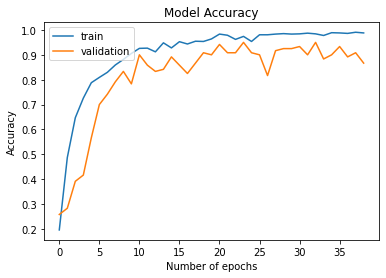

In [22]:
#plt.figure(figsize = (10,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

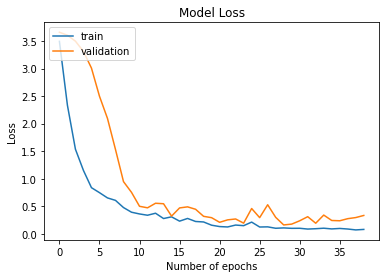

In [23]:
# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [24]:
num_predictions = 100
correct_pred = 0
pred = np.argmax(model.predict(x_test[0:num_predictions]), axis=-1)
print_count = 0

print("Predicted class : Class label")
for i in range(num_predictions):
    label = np.argmax(y_test[i])
    #print(pred[i], "=?", label)
    print("{:2s} : {:2s}".format(str(pred[i]), str(label)), end= "     ")
    
    print_count += 1
    if print_count == 5:
        print()
        print_count = 0

    if pred[i] == label:
        correct_pred += 1

print("\nTotal correct predictions:", correct_pred)
print("Percent correct:", correct_pred/num_predictions)

Predicted class : Class label
0  : 0      4  : 4      4  : 4      4  : 4      3  : 3      
4  : 4      4  : 4      3  : 3      1  : 1      0  : 0      
3  : 3      2  : 1      1  : 1      3  : 3      1  : 1      
4  : 2      3  : 0      2  : 2      1  : 1      1  : 1      
3  : 3      2  : 2      1  : 1      2  : 2      1  : 1      
0  : 0      0  : 2      1  : 1      4  : 4      2  : 2      
1  : 1      4  : 4      4  : 4      4  : 4      0  : 0      
1  : 1      0  : 0      1  : 1      0  : 0      2  : 2      
1  : 1      2  : 2      2  : 2      1  : 1      3  : 3      
2  : 2      3  : 3      4  : 4      1  : 1      1  : 1      
4  : 2      4  : 4      1  : 1      2  : 2      4  : 2      
2  : 2      0  : 0      3  : 0      4  : 4      4  : 2      
0  : 0      4  : 4      4  : 4      3  : 0      0  : 0      
1  : 1      4  : 4      4  : 2      3  : 3      1  : 1      
4  : 0      0  : 0      3  : 3      3  : 0      4  : 4      
1  : 1      3  : 3      3  : 3      4  : 4      3  : 0 

### Create EEG feature vectors

In [161]:
# use the model to extract eeg feature vectors
# use output from an intermediate layer
def extract_features(data, model, feature_layer):
    # reshape the data for CNN
    data = data.transpose(0, 2, 1)
    data = data.reshape(data.shape[0], data.shape[1], data.shape[2], 1)
    # use intermediate layer
    feature_extractor = tensorflow.keras.Model(inputs=model.input,
                                               outputs=model.get_layer(feature_layer).output)
    #features = feature_extractor(data)

    OPT = keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
    feature_extractor.compile(loss='categorical_crossentropy', optimizer = OPT, metrics = ['accuracy'])

    features = feature_extractor.predict(data)

    return features

In [162]:
for layer in model.layers:
    print(layer.name)

batch_normalization_21
conv2d_17
conv2d_18
max_pooling2d_4
conv2d_19
max_pooling2d_5
conv2d_20
flatten_5
batch_normalization_22
dense_10
batch_normalization_23
dense_11


In [163]:
print(data.shape)

(600, 440, 128)


In [165]:
features = extract_features(data, model, 'dense_10')
print(features.shape)
print(labels.shape)
print("Features:", features)

(600, 100)
(600,)
Features: [[0.37342376 0.28916675 0.         ... 0.02287926 0.21844617 0.01477854]
 [0.41177338 0.33052576 0.01761427 ... 0.00991638 0.24404058 0.        ]
 [0.         0.         0.2428     ... 0.14176542 0.         0.21879311]
 ...
 [0.         0.         0.30857676 ... 0.1103079  0.         0.2404663 ]
 [0.3302551  0.31460258 0.         ... 0.02654708 0.25960413 0.        ]
 [0.35833114 0.2702504  0.         ... 0.03382869 0.19305795 0.        ]]


In [166]:
save("/content/gdrive/MyDrive/EEG2Image/data/eeg_feature_vectors_2_class.npy", features)
save("/content/gdrive/MyDrive/EEG2Image/data/labels_2_class.npy", labels)

### Confusion matrix code reference:
https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826

In [72]:
# convert from one hot to class number
Y_test = []
for y in y_test:
    Y_test.append(np.argmax(y))
y_test = np.asarray(Y_test)

# make predictions
y_pred = np.argmax(model.predict(x_test), axis=-1)

In [73]:
import pandas as pd
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, y_pred)

df = pd.DataFrame(confusion)
def highlight_diag(df):
    a = np.full(df.shape, '', dtype='<U24')
    np.fill_diagonal(a, 'background-color: yellow')
    return pd.DataFrame(a, index=df.index, columns=df.columns)

df.style.apply(highlight_diag, axis=None)


In [74]:
#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))


Accuracy: 1.00

Micro Precision: 1.00
Micro Recall: 1.00
Micro F1-score: 1.00

Macro Precision: 1.00
Macro Recall: 1.00
Macro F1-score: 1.00

Weighted Precision: 1.00
Weighted Recall: 1.00
Weighted F1-score: 1.00


In [75]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred))


Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        58

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



# Loading Image Net dataset

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import collections
import tensorflow as tf

In [5]:
def array_to_image(img):
    return img.reshape(3, 64, 64).transpose(1, 2, 0) / np.float32(255)


def save_images(image_mapping_array, label_number):
    images = image_mapping_array[label_number]

    # Loop through all images for a specific label and save them
    for index, image in enumerate(images):
        img = array_to_image(image)
        plt.imsave("images/" + str(index) + ".png", img, format="png")


def load_mapping(path, as_dict=False):
    # Load image mapping file
    label2image64 = np.load(path, allow_pickle=True)
    if as_dict:
        return label2image64[()]
    else:
        # Create a numpy ready array of image mappings [[class 0 images], [class 1 images], ... , [class 39 images]]
        return list(collections.OrderedDict(sorted(label2image64[()].items())).values())

In [6]:
# only exec once to copy image_mapping.npy over to local
!ls /content/gdrive/MyDrive/EEG2Image/data/
!cp /content/gdrive/MyDrive/EEG2Image/data/image_mapping.npy /content/

eeg_feature_vectors_2_class.npy  image_mapping.npy   labels_55_95.npy
eeg_norm_linear_55_95.npy	 images.npy	     labels_5_95.npy
eeg_norm_sigmoid_55_95.npy	 labels_14_70.npy
image_labels.npy		 labels_2_class.npy


In [7]:
def convert_data(data, image_shape=(64,64,3), scale=True):
    print("Converting data shape to 2D with 3 channels")
    if len(image_shape) != 3:
        print("Unexpected image_shape in convert_data")
        return -1
    # change the dimensions and scale
    # create new list to store the data in the correct format
    formatted_data = []
    count = 0
    for image in data:
        count += 1
        # convert from flat to 2D
        # formatted_data.append(array_to_image(image)) # that function changes bounds
        reshaped = image.reshape(3, 64, 64).transpose(1, 2, 0)
        formatted_data.append(reshaped)
    X = np.asarray(formatted_data)
    if scale:
        print("scaling values to the range [-1, 1]")
        X = X.astype('float32') # caution: storing lots of intermediate representation of image set
        X = (X - 127.5) / 127.5
    print("formatted shape:", X.shape)
    return X

In [8]:
def augment_data(images, labels):
    augmented = []
    augmented_labels = []
    for i, image in enumerate(images):
        flipped = tf.image.flip_left_right(image)
        
        augmented.append(image)
        augmented.append(flipped)

        augmented_labels.append(labels[i])
        augmented_labels.append(labels[i])
        
    return np.asarray(augmented), np.asarray(augmented_labels)

In [9]:
# emulate the load_data() function but only return (images, labels)
# scale flag scales the input to [-1, 1] if true
def load_image_net_data(scale=True, flip=True):
    mapping = load_mapping("image_mapping.npy", as_dict=False)
    # images stored as flat
    images = []
    num_images_per_class = 900
    for elem in mapping:
        images.append(np.asarray(elem[0:num_images_per_class])) # not all the same size so trim to 900 images per class
    images = np.asarray(images)
    num_classes = images.shape[0]
    print("shape of the data:", images.shape) # (40, 900, 12288) but want (900, 64, 64, 3)
    print("classes:", images.shape[0])
    print("images per class:", images.shape[1])
    print("pixel values in images:", images.shape[2])
    
    # append all classes into one list
    mapping = []
    for image_class in range(num_classes):
        for image in range(num_images_per_class):
            # append this image to one long new list
            mapping.append(images[image_class][image])
    mapping = np.asarray(mapping)
    print("shape after removing classes:", mapping.shape)

    data = convert_data(mapping, (64,64,3), scale)

    # create the labels
    labels = np.arange(0, 40, 1) # create labels 0 -> 39
    labels = np.repeat(labels, num_images_per_class) # repeat each label for num images per class

    if flip:
        data, labels = augment_data(data, labels)
    return data, labels

In [10]:
printFlag = False
if printFlag:
    trainX, trainY = load_image_net_data(scale=False)
    print(trainX.shape)
    print(trainY.shape)
    print("min:", np.amin(trainX[0]))
    print("max:", np.amax(trainY[1]))
    images_per_class = 900
    print("Showing the first 10 images classes")
    plt.figure(figsize=(20, 20))
    # plot images from the training dataset
    for i in range(100):
    	# define subplot
    	plt.subplot(10, 10, 1 + i)
    	# turn off axis
    	plt.axis('off')
    	# plot raw pixel data
    	# every 10, skip rest of images in the class
    	#plt.imshow(array_to_image( trainX[i + ((i//10)*images_per_class)] ))
    	plt.imshow( trainX[i + ((i//10)*images_per_class)] )
    plt.show()

**done loading images**

# AC-GAN
Reference to the blogpost that details a base AC-GAN implementation<br>
https://machinelearningmastery.com/how-to-develop-an-auxiliary-classifier-gan-ac-gan-from-scratch-with-keras/
<br>

- building up the GAN from just convolutions...
    - use ReLU
    - BatchNormalization and Dropout are ruining results for now
        - because discriminator does not learn enough with this regularization?
        - add back if overfitting or cannot generalize
    - **3x3** kernel in **discriminator** for all these tests so far
    - upsampling
        - Conv2DT = comparable to best
        - nearest neighbor = best so far (use this one)
        - bilinear = poor results
    - tried 2x2, 3x3, 5x5 kernel in **generator** - 2x2 the best so far
        - use **2x2**
        - 5x5 = bad results
        - 3x3 = white blobs

### To Do:

### Progress

### Tried:


In [118]:
# example of fitting an auxiliary classifier gan (ac-gan) 
from math import sqrt
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from numpy.random import random
from numpy.random import choice
import tensorflow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import Softmax
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K 
from matplotlib import pyplot

In [12]:
import datetime
dt = datetime.datetime.today()

In [13]:
# Define default number of classes
NUM_CLASSES = 1

In [14]:
def model_info(model, name):
    model.summary()
    plot_model(model, to_file=name+'.png', show_shapes=True, show_layer_names=True)

In [227]:
print("Give a name to this experiment:")
experiment_name = input()

Give a name to this experiment:
1C_SAGAN


## Discriminators

### AC-GAN Discriminator Models

In [168]:
# following DCGAN architecture
def define_discriminator_AC_DCGAN(in_shape=(64,64,3), n_classes=NUM_CLASSES, lr=0.0002, beta_1=0.5, beta_2=0.999):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=in_shape)
	# downsample to 32x32
	fe = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# downsample to 16x16
	fe = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# downsample to 8x8
	fe = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# downsample to 4x4
	fe = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
    # there was a "normal" convolution layer here that did not downsample before
	# flatten feature maps
	fe = Flatten()(fe)
	# real/fake output
	out1 = Dense(1, activation='sigmoid')(fe)
	# class label output
	out2 = Dense(n_classes, activation='softmax')(fe)
	# define model
	model = Model(in_image, [out1, out2], name='Discriminator_AC_DCGAN')
	# compile model
	opt = Adam(lr=lr, beta_1=beta_1, beta_2=_beta_2)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	return model

In [25]:
# define the standalone discriminator model
def define_discriminator_ALEX(in_shape=(64,64,3), n_classes=NUM_CLASSES, lr=0.0002, beta_1=0.5, beta_2=0.999):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # normal
    fe = Conv2D(128, (4,4), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample to 32x32
    fe = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization(momentum=0.3)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample to 16x16
    fe = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization(momentum=0.3)(fe)
    fe = LeakyReLU( alpha=0.2)(fe)
    # downsample to 8x8
    fe = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization(momentum=0.3)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2], name="Discriminator_ALEX")
    # compile model
    opt = Adam(lr=lr, beta_1=beta_1, beta_2=beta_2)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

In [210]:
# define the standalone discriminator model
def define_discriminator_EEG(in_shape=(64,64,3), n_classes=NUM_CLASSES, lr=0.0002, beta_1=0.5, beta_2=0.999):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # normal
    fe = Conv2D(128, (4,4), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample to 32x32
    fe = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization(momentum=0.3)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample to 16x16
    fe = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization(momentum=0.3)(fe)
    fe = LeakyReLU( alpha=0.2)(fe)
    # downsample to 8x8
    fe = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization(momentum=0.3)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2], name="Discriminator_EEG")
    # compile model
    opt = Adam(lr=lr, beta_1=beta_1, beta_2=beta_2)
    #model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=opt)
    return model

### Base GAN Discriminator Models

In [19]:
# discriminator for base GAN
def define_discriminator_BASE_GAN(in_shape=(64,64,3), lr=0.0002, beta_1=0.5):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 32x32
    fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 16x16
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 8x8
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # define model
    model = Model(in_image, out1, name='Discriminator_BASE_GAN')
    # compile model
    opt = Adam(lr=lr, beta_1=beta_1)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [20]:
# following DCGAN architecture
def define_discriminator_DCGAN(in_shape=(64,64,3), lr=0.0002, beta_1=0.5, beta_2=0.999):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=in_shape)
	# downsample to 32x32
	fe = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# downsample to 16x16
	fe = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# downsample to 8x8
	fe = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# downsample to 4x4
	#fe = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(fe)
	#fe = BatchNormalization()(fe)
	#fe = LeakyReLU(alpha=0.2)(fe)
	#fe = Dropout(0.5)(fe)
    # there was a "normal" convolution layer here that did not downsample before
	# flatten feature maps
	fe = Flatten()(fe)
	# real/fake output
	out1 = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model(in_image, out1, name='Discriminator_DCGAN')
	# compile model
	opt = Adam(lr=lr, beta_1=beta_1, beta_2=beta_2)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# following DCGAN architecture
def define_discriminator_DCGAN(in_shape=(64,64,3), lr=0.001, beta_1=0.9, beta_2=0.999):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=in_shape)
	# downsample to 32x32
	fe = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# downsample to 16x16
	fe = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# downsample to 8x8
	fe = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# real/fake output
	out1 = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model(in_image, out1, name='Discriminator_simplified_DCGAN')
	# compile model
	opt = Adam(lr=lr, beta_1=beta_1, beta_2=beta_2)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model


# following AC-GAN paper architecture without the AC
def define_discriminator_DCGAN(in_shape=(64,64,3), lr=0.0002, beta_1=0.5, beta_2=0.999):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=in_shape)
	# downsample to 32x32
	fe = Conv2D(16, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
    # normal
	fe = Conv2D(32, (3,3), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# downsample to 16x16
	fe = Conv2D(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
    # normal
	fe = Conv2D(128, (3,3), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# downsample to 8x8
	fe = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
    # normal
	fe = Conv2D(512, (3,3), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# real/fake output
	out1 = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model(in_image, out1, name='Discriminator_AC-GAN_paper')
	# compile model
	opt = Adam(lr=lr, beta_1=beta_1, beta_2=beta_2)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# working up from just conv
def define_discriminator(in_shape=(64,64,3), lr=0.0002, beta_1=0.5, beta_2=0.999):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=in_shape)
	# downsample to 32x32
	fe = Conv2D(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample to 16x16
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample to 8x8
	fe = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# real/fake output
	out1 = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model(in_image, out1, name='Discriminator_3x3_w_ReLU')
	# compile model
	opt = Adam(lr=lr, beta_1=beta_1, beta_2=beta_2)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

## Generators

### AC-GAN Generator Models

In [158]:
# generatorv6 - following DCGAN structure (same as genv5...)
def define_generator_AC_DCGAN(latent_dim, n_classes=NUM_CLASSES):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
    # 4x4 = 16 which is way less than 50 nodes. this is okay for now but try adding it as more channels
	n_nodes = 4 * 4
	li = Dense(n_nodes, kernel_initializer=init)(li)
	# reshape to additional channel
	li = Reshape((4, 4, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 4x4 image
	n_nodes = 1023 * 4 * 4
	gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
	gen = Activation('relu')(gen)
	gen = Reshape((4, 4, 1023))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li]) # 1023 + 1 for 1024 total
	# upsample to 8x8
	gen = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merge)
	gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)
	# upsample to 16x16
	gen = Conv2DTranspose(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)
	# upsample to 32x32
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)
	# upsample to 64x64
	gen = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    # should there be batch normalization here or does that mess with tanh?
	out_layer = Activation('tanh')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer, name='Generator_AC_DCGAN')
	return model

In [27]:
# define the standalone generator model
def define_generator_ALEX(latent_dim=100, n_classes=NUM_CLASSES):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    # n_nodes = 7 * 7
    n_nodes = 8*8* 3
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((8, 8, 3))(li)
    
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    # n_nodes = 384 * 7 * 7
    n_nodes = 256 * 8 * 8
    lat = Dense(n_nodes, kernel_initializer=init)(in_lat)
    lat = LeakyReLU(alpha=0.2)(lat)
    lat = Reshape((8, 8, 256))(lat)
    # merge image gen and label input
    merge = Concatenate()([lat, li])
#     # upsample to 8x8
#     gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merge)
#     gen = BatchNormalization()(gen)
#     gen = LeakyReLU(alpha=0.2)(gen)

    # upsample to 16x16
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization(momentum=0.3)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    # upsample to 32x32
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = BatchNormalization(momentum=0.3)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    # upsample to 64x64
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
#     gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    gen = Conv2D(3, (3,3), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer, name="Generator_ALEX")
    return model

In [211]:
# define the standalone generator model
def define_generator_EEG(latent_dim=100, n_classes=NUM_CLASSES):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(100,))
    # linear multiplication
    n_nodes = 8*8*3
    li = Dense(n_nodes, kernel_initializer=init)(in_label)
    # reshape to additional channel
    li = Reshape((8, 8, 3))(li)
    
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    n_nodes = 256 * 8 * 8
    lat = Dense(n_nodes, kernel_initializer=init)(in_lat)
    lat = LeakyReLU(alpha=0.2)(lat)
    lat = Reshape((8, 8, 256))(lat)
    # merge image gen and label input
    merge = Concatenate()([lat, li])
#     # upsample to 8x8
#     gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merge)
#     gen = BatchNormalization()(gen)
#     gen = LeakyReLU(alpha=0.2)(gen)

    # upsample to 16x16
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization(momentum=0.3)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    # upsample to 32x32
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = BatchNormalization(momentum=0.3)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    # upsample to 64x64
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    gen = Conv2D(3, (3,3), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer, name="Generator_EEG")
    return model

### Base GAN Generator Models

In [16]:
# regular GAN no AC v4
def define_generator_BASE_GAN(latent_dim, n_classes=NUM_CLASSES):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 8x8 image
	n_nodes = 128 * 8 * 8
	gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
	gen = Activation('relu')(gen)
	gen = Reshape((8, 8, 128))(gen)
	# upsample to 16x16
	gen = Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)
	# upsample to 32x32
	gen = Conv2DTranspose(32, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)
	# upsample to 64x64
	gen = Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	out_layer = Activation('tanh')(gen)
	# define model
	model = Model(in_lat, out_layer, name='Generator_BASE_GAN')
	return model

# regular GAN w nearest neighbor interpolation
def define_generator_BASE_GAN(latent_dim, n_classes=NUM_CLASSES):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 8x8 image
    n_nodes = 128 * 8 * 8
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((8, 8, 128))(gen)
    # upsample to 16x16
    gen = UpSampling2D(size=(2,2), interpolation='nearest')(gen)
    gen = Conv2D(64, (5,5), padding='same', kernel_initializer=init)(gen)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 32x32
    gen = UpSampling2D(size=(2,2), interpolation='nearest')(gen)
    gen = Conv2D(32, (5,5), padding='same', kernel_initializer=init)(gen)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 64x64
    gen = UpSampling2D(size=(2,2), interpolation='nearest')(gen)
    gen = Conv2D(3, (5,5), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model(in_lat, out_layer, name='Generator_BASE_GAN_nearest_neighbor')
    return model

In [110]:
# following DCGAN structure 
def define_generator_DCGAN(latent_dim):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	## foundation for 4x4 image
	#n_nodes = 1024 * 4 * 4
	#gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
	#gen = Activation('relu')(gen)
	#gen = Reshape((4, 4, 1024))(gen)
	## upsample to 8x8
	#gen = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	#gen = BatchNormalization()(gen)
	#gen = Activation('relu')(gen)

	# foundation for 8x8 image
	n_nodes = 128 * 8 * 8
	gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
	gen = Activation('relu')(gen)
	gen = Reshape((8, 8, 128))(gen)

	# upsample to 16x16
	gen = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)
	# upsample to 32x32
	gen = Conv2DTranspose(32, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)
	# upsample to 64x64
	gen = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    # should there be batch normalization here or does that mess with tanh?
	out_layer = Activation('tanh')(gen)
	# define model
	model = Model(in_lat, out_layer, name='Generator_DCGAN')
	return model

# following DCGAN structure 
def define_generator_DCGAN(latent_dim):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image generator input
	in_lat = Input(shape=(latent_dim,))

	# foundation for 8x8 image
	n_nodes = 128 * 8 * 8
	gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
	gen = Activation('relu')(gen)
	gen = Reshape((8, 8, 128))(gen)

	# upsample to 16x16
	gen = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)
	# upsample to 32x32
	gen = Conv2DTranspose(32, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)
	# upsample to 64x64
	gen = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    # should there be batch normalization here or does that mess with tanh?
	out_layer = Activation('tanh')(gen)
	# define model
	model = Model(in_lat, out_layer, name='Generator_simplified_DCGAN')
	return model

# following aC-GAN paper without the AC
def define_generator_DCGAN(latent_dim):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 8x8 image
	n_nodes = 384 * 8 * 8
	gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
	gen = Activation('relu')(gen)
	gen = Reshape((8, 8, 384))(gen)
	# upsample to 16x16
	gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)
	# upsample to 32x32
	gen = Conv2DTranspose(96, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)
	# upsample to 64x64
	gen = Conv2DTranspose(3, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    # should there be batch normalization here or does that mess with tanh?
	out_layer = Activation('tanh')(gen)
	# define model
	model = Model(in_lat, out_layer, name='Generator_AC-GAN_paper')
	return model

# 3x3 - working up from just conv
def define_generator_DCGAN(latent_dim):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image generator input
	in_lat = Input(shape=(latent_dim,))

	# foundation for 8x8 image
	n_nodes = 128 * 8 * 8
	gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
	gen = Activation('relu')(gen)
	gen = Reshape((8, 8, 128))(gen)

	# upsample to 16x16
	gen = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = Activation('relu')(gen)
	# upsample to 32x32
	gen = Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = Activation('relu')(gen)
	# upsample to 64x64
	gen = Conv2DTranspose(3, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    # should there be batch normalization here or does that mess with tanh?
	out_layer = Activation('tanh')(gen)
	# define model
	model = Model(in_lat, out_layer, name='Generator_3x3_w_ReLU')
	return model


# 3x3 - working up from just conv - using bilinear interpolation
def define_generator_DCGAN(latent_dim):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image generator input
    in_lat = Input(shape=(latent_dim,))

    # foundation for 8x8 image
    n_nodes = 128 * 8 * 8
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((8, 8, 128))(gen)

    # upsample to 16x16
    gen = UpSampling2D(size=(2,2), interpolation='bilinear')(gen)
    gen = Conv2D(32, (2,2), padding='same', kernel_initializer=init)(gen)
    gen = Activation('relu')(gen)

    # upsample to 32x32
    gen = UpSampling2D(size=(2,2), interpolation='bilinear')(gen)
    gen = Conv2D(32, (2,2), padding='same', kernel_initializer=init)(gen)
    gen = Activation('relu')(gen)

    # upsample to 64x64
    gen = UpSampling2D(size=(2,2), interpolation='bilinear')(gen)
    gen = Conv2D(3, (2,2), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    
    # define model
    model = Model(in_lat, out_layer, name='Generator_2x2_w_ReLU_bilinear_interp')
    return model

# 3x3 - working up from just conv - using nearest neighbor
def define_generator(latent_dim):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image generator input
    in_lat = Input(shape=(latent_dim,))

    # foundation for 8x8 image
    n_nodes = 128 * 8 * 8
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((8, 8, 128))(gen)

    # upsample to 16x16
    gen = UpSampling2D(size=(2,2), interpolation='nearest')(gen)
    gen = Conv2D(32, (2,2), padding='same', kernel_initializer=init)(gen)
    gen = Activation('relu')(gen)

    # upsample to 32x32
    gen = UpSampling2D(size=(2,2), interpolation='nearest')(gen)
    gen = Conv2D(32, (2,2), padding='same', kernel_initializer=init)(gen)
    gen = Activation('relu')(gen)

    # upsample to 64x64
    gen = UpSampling2D(size=(2,2), interpolation='nearest')(gen)
    gen = Conv2D(3, (2,2), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    
    # define model
    model = Model(in_lat, out_layer, name='Generator_2x2_w_ReLU_nearest_neighbor')
    return model

## GAN Combination and Helper Functions

### Helper Functions (Compile at least once)

In [21]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=NUM_CLASSES): # set NUM_CLASSES to 0 for Base GAN
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

### AC-GAN

In [190]:
def calculate_accuracy(dataset, discriminator, generator, latent_dim=100, n_samples=100):
    # prepare real samples
    [X_real, X_labels], y_real = generate_real_samples(dataset, n_samples)
    real_pred = discriminator.predict(X_real)
    # prepare fake examples
    [x_fake, x_labels_fake], y_fake = generate_fake_samples_AC_GAN(generator, latent_dim, n_samples)
    fake_pred = discriminator.predict(x_fake)

    real_correct = 0
    fake_correct = 0
    for pred in real_pred[0]:
        if pred > 0.5:
            real_correct += 1

    for pred in fake_pred[0]:
        if pred < 0.5:
            fake_correct += 1

    real_correct = real_correct/n_samples
    fake_correct = fake_correct/n_samples

    print("Real:", real_correct)
    print("Fake:", fake_correct)
    return real_correct, fake_correct

In [191]:
# generate samples and save as a plot and save the model
def summarize_performance_AC_GAN(step, g_model, d_model, gan_model, latent_dim, bat_per_epo = 140, n_samples=100): # modify this to save in google drive
    # prepare fake examples
    [X, _], _ = generate_fake_samples_AC_GAN(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    pyplot.figure(figsize=(15,15))
    # plot images
    for i in range(100):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i])
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()

    # save the generator model
    g_filename = 'generator_%04d.h5' % (step+1)
    g_model.save(g_filename)

    # save the discriminator model
    d_filename = 'discriminator_%04d.h5' % (step+1)
    d_model.trainable=True
    d_model.save(d_filename)
    d_model.trainable=False

    # save the GAN model
    gan_filename = 'gan_%04d.h5' % (step+1)
    gan_model.save(gan_filename)
    print('>Saved: %s, %s, %s and %s' % (filename1, g_filename, d_filename, gan_filename))

    # accuracy
    acc_real, acc_fake = calculate_accuracy(dataset, d_model, g_model, latent_dim, n_samples)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))


In [192]:
# function that takes in 3 lists of (1,3) tuples and returns 3 (1,3) tuples of average loss across the  epoch
def avg_loss_per_epo(d_real_losses, d_fake_losses, g_losses, bat_per_epo):
    d_r_sums = [0, 0, 0]
    d_f_sums = [0, 0, 0]
    g_sums = [0, 0, 0]
    # sum the losses per batch
    for total_loss, r_f_loss, class_loss in d_real_losses:
        d_r_sums[0] += total_loss
        d_r_sums[1] += r_f_loss
        d_r_sums[2] += class_loss
    # averaged the losses over the epoch
    for i in range(len(d_r_sums)):
        d_r_sums[i] /= bat_per_epo

    # sum the losses per batch
    for total_loss, r_f_loss, class_loss in d_fake_losses:
        d_f_sums[0] += total_loss
        d_f_sums[1] += r_f_loss
        d_f_sums[2] += class_loss
    # averaged the losses over the epoch
    for i in range(len(d_r_sums)):
        d_f_sums[i] /= bat_per_epo

    # sum the losses per batch
    for total_loss, r_f_loss, class_loss in g_losses:
        g_sums[0] += total_loss
        g_sums[1] += r_f_loss
        g_sums[2] += class_loss
    # averaged the losses over the epoch
    for i in range(len(d_r_sums)):
        g_sums[i] /= bat_per_epo
    return d_r_sums, d_f_sums, g_sums

In [193]:
#feature_vectors = load("...")
#feature_vector_labels = load("...")

feature_vectors = features
feature_vector_labels = labels
print(feature_vectors.shape)
print(feature_vector_labels.shape)

(600, 100)
(600,)


In [194]:
# get a random EEG feature vector and its corresponding label
def generate_feature_vector(n_samples):
    # random instances
    ix = randint(0, feature_vectors.shape[0], n_samples)
    X, labels = feature_vectors[ix], feature_vector_labels[ix]
    y = zeros((n_samples, 1))
    return X, labels

In [212]:
# define the combined generator and discriminator model, for updating the generator
def define_AC_GAN(g_model, d_model, lr=0.0002, beta_1=0.5, beta_2=0.999):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# connect the outputs of the generator to the inputs of the discriminator
	gan_output = d_model(g_model.output)
	# define gan model as taking noise and label and outputting real/fake and label outputs
	model = Model(g_model.input, gan_output, name="Combined_AC_GAN")
	# compile model
	opt = Adam(lr=lr, beta_1=beta_1, beta_2=beta_2)
	#model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=opt)
	return model

# use the generator to generate n fake examples, with class labels
def generate_fake_samples_AC_GAN(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    
    # AC-GAN with EEG vector as condition
    f_vectors, labels_input = generate_feature_vector(n_samples)
    images = generator.predict([z_input, f_vectors])
    
    # regular AC-GAN with class  as condition
    #images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

def train_AC_GAN(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1000, n_batch=64):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # lists used to save losses over batches and over epochs
    d_rs = []
    d_fs = []
    gs = []
    d_rs_epo = []
    d_fs_epo = []
    gs_epo = []
    # manually enumerate epochs
    for i in range(n_steps):
        if i % bat_per_epo == 0 and i > 0:
            print("\nEpoch", int(i/bat_per_epo))
            # compute averages
            d_r_avgs, d_f_avgs, g_avgs = avg_loss_per_epo(d_rs, d_fs, gs, bat_per_epo)
            print("Discriminator real images total loss: %.3f, real/fake loss: %.3f, classification loss: %.3f" % (d_r_avgs[0], d_r_avgs[1], d_r_avgs[2]))
            print("Discriminator fake images total loss: %.3f, real/fake loss: %.3f, classification loss: %.3f" % (d_f_avgs[0], d_f_avgs[1], d_f_avgs[2]))
            print("Generator (fake images) total loss: %.3f, real/fake loss: %.3f, classification loss: %.3f" % (g_avgs[0], g_avgs[1], g_avgs[2]))
            d_rs_epo.append( d_r_avgs ) # average disciminator loss on real samples
            d_fs_epo.append( d_f_avgs ) # average disciminator loss on fake samples
            gs_epo.append( g_avgs ) # average generator loss on real samples
            # reset counts per epoch
            d_rs = []
            d_fs = []
            gs = []
        
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        d_r0,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])

        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples_AC_GAN(g_model, latent_dim, half_batch)
        # update discriminator model weights
        d_f0,d_f1,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])

        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        g_0,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])

        # summarize loss on this batch
        d_rs.append((d_r0, d_r1, d_r2))
        d_fs.append((d_f0, d_f1, d_f2))
        gs.append((g_0, g_1, g_2))
        #print('>%d, dr[%.3f,%.3f,%.4f], df[%.3f,%.3f,%.4f], g[%.3f,%.3f,%.4f]' % (i+1, d_r0, d_r1,d_r2, d_f0, d_f1,d_f2, g_0, g_1,g_2))
        # evaluate the model performance every 10 'epoch'
        if (i+1) % (bat_per_epo * 100) == 0:
            summarize_performance_AC_GAN(i, g_model, d_model, gan_model, latent_dim, bat_per_epo)
    d_rs_epo = np.asarray(d_rs_epo)
    d_fs_epo = np.asarray(d_fs_epo)
    gs_epo = np.asarray(gs_epo)
    return [d_rs_epo, d_fs_epo, gs_epo] 

### Base GAN

In [22]:
# generate samples and save as a plot and save the model
def summarize_performance_BASE_GAN(step, g_model, latent_dim, bat_per_epo=140, n_samples=100): # modify this to save in google drive
	# prepare fake examples
	[X, _], _ = generate_fake_samples_BASE_GAN(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	pyplot.figure(figsize=(15,15))
	# plot images
	for i in range(100):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i])
	# save plot to file
	filename1 = 'generated_plot_%04d.png' % (step+1) 
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%04d.h5' % (step+1) 
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [23]:
# non AC-GAN changes
# define the combined generator and discriminator model, for updating the generator
def define_BASE_GAN(g_model, d_model, lr=0.0002, beta_1=0.5, beta_2=0.999):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# connect the outputs of the generator to the inputs of the discriminator
	gan_output = d_model(g_model.output)
	# define gan model as taking noise and label and outputting real/fake and label outputs
	model = Model(g_model.input, gan_output, name="Combined_BASE_GAN")
	# compile model
	opt = Adam(lr=lr, beta_1=beta_1, beta_2=beta_2)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

def generate_fake_samples_BASE_GAN(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict(z_input)
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# train function for nonAC GAN
def train_BASE_GAN(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1000, n_batch=64):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    d_rs = [] # loss per batch used for averaging across epoch
    d_fs = []
    gs = []
    d_rs_epo = [] # averaged losses per epoch
    d_fs_epo = []
    gs_epo = []
    # manually enumerate epochs
    for i in range(n_steps):
        if i % bat_per_epo == 0 and i > 0:
            print("\nEpoch", int(i/bat_per_epo))
            avg_loss_d_r = (sum(d_rs[:])/bat_per_epo)
            avg_loss_d_f = (sum(d_fs[:])/bat_per_epo)
            avg_loss_g = (sum(gs[:])/bat_per_epo)
            print("Average discriminator loss:", avg_loss_d_r)
            print("Average discriminator loss on fake images:", avg_loss_d_f)
            print("Average generator loss:", avg_loss_g)

            d_rs_epo.append( avg_loss_d_r ) # average disciminator loss on real samples
            d_fs_epo.append( avg_loss_d_f ) # average disciminator loss on fake samples
            gs_epo.append( avg_loss_g ) # average generator loss on real samples
            d_rs = []
            d_fs = []
            gs = []
            

        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        d_r1 = d_model.train_on_batch(X_real, y_real)

        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples_BASE_GAN(g_model, latent_dim, half_batch)
        # update discriminator model weights
        d_f = d_model.train_on_batch(X_fake, y_fake)

        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error

        # base GAN no AC
        g_1 = gan_model.train_on_batch(z_input, y_gan)

        # summarize loss on this batch
        d_rs.append(d_r1)
        d_fs.append(d_f)
        gs.append(g_1)
        # evaluate the model performance every 'epoch'
        if (i+1) % (bat_per_epo * 100) == 0:
            summarize_performance_BASE_GAN(i, g_model, latent_dim)
    d_rs_epo = np.asarray(d_rs_epo)
    d_fs_epo = np.asarray(d_fs_epo)
    gs_epo = np.asarray(gs_epo)
    return [d_rs_epo, d_fs_epo, gs_epo] 

## Define Hyper-parameters and Create Model

In [234]:
# Hyper Parameter Tuning
latent_dim = 100 # size of the latent space
NUM_EPOCHS = 1000
BATCH_SIZE = 64

# hyper parameters from SAGAN paper
LR_D = 0.0004
LR_G = 0.0001
BETA_1_D = 0
BETA_2_D = 0.9
BETA_1_G = 0
BETA_2_G = 0.9

# default Adam parameters
# LR_D = 0.001
# LR_G = 0.001
# BETA_1_D = 0.9
# BETA_2_D = 0.999
# BETA_1_G = 0.9
# BETA_2_G = 0.999
# NUM_EPOCHS = 1000
# BATCH_SIZE = 64

# hyper parameters from AC-GAN paper
#LR_D = 0.0002
#LR_G = 0.0002
#BETA_1_D = 0.5
#BETA_2_D = 0.999
#BETA_1_G = 0.5
#BETA_2_G = 0.999
#NUM_EPOCHS = 1000
#BATCH_SIZE = 64


In [ ]:
# Base GAN
print("Creating Base GAN")
# create the discriminator
discriminator = define_discriminator(lr=LR_D, beta_1=BETA_1_D, beta_2=BETA_2_D)
model_info(discriminator, "discriminator")

# create the generator
generator = define_generator(latent_dim)
model_info(generator, "generator")

# create the gan
gan_model = define_BASE_GAN(generator, discriminator, lr=LR_G, beta_1=BETA_1_G, beta_2=BETA_2_G)
model_info(gan_model, "base_GAN_model")

In [235]:
# SN-GAN
print("Creating Self Attention GAN")
# create the discriminator
discriminator = define_discriminator_SNGAN(lr=LR_D, beta_1=BETA_1_D, beta_2=BETA_2_D)
model_info(discriminator, "discriminator")

# create the generator
generator = define_generator_SAGAN(latent_dim)
generator.summary()
#model_info(generator, "generator")

# create the gan
gan_model = define_BASE_GAN(generator, discriminator, lr=LR_G, beta_1=BETA_1_G, beta_2=BETA_2_G)
gan_model.summary()
#model_info(gan_model, "Base_D_SN_G_GAN")

Creating Self Attention GAN
Model: "SN-Discriminator_3x3_kernel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_74 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
spectral_normalization_187 ( (None, 32, 32, 64)        1856      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
spectral_normalization_188 ( (None, 16, 16, 128)       73984     
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
spectral_normalization_189 ( (None, 8, 8, 256)         295424    
_________________________________________________________________
leaky_re_lu

In [ ]:
# AC-GAN
print("Creating AC-GAN")
# create the discriminator
discriminator = define_discriminator_EEG(lr=LR_D, beta_1=BETA_1_D, beta_2=BETA_2_D)
model_info(discriminator, "discriminator")

# create the generator
generator = define_generator_EEG(latent_dim)
model_info(generator, "generator")

# create the gan
gan_model = define_AC_GAN(generator, discriminator, lr=LR_G, beta_1=BETA_1_G, beta_2=BETA_2_G)
model_info(gan_model, "AC_GAN_model")

In [34]:
# load image data
flip = True
x, y = load_image_net_data(scale=True, flip=flip)

print("Restricting to", NUM_CLASSES, "classes")
IMG_PER_CLASS = 900

if flip:
    x = x[0:IMG_PER_CLASS * NUM_CLASSES * 2]
    y = y[0:IMG_PER_CLASS * NUM_CLASSES * 2]
else:
    x = x[0:IMG_PER_CLASS * NUM_CLASSES]
    y = y[0:IMG_PER_CLASS * NUM_CLASSES]
print(x.shape)
print(y.shape)
dataset = [x, y]

shape of the data: (40, 900, 12288)
classes: 40
images per class: 900
pixel values in images: 12288
shape after removing classes: (36000, 12288)
Converting data shape to 2D with 3 channels
scaling values to the range [-1, 1]
formatted shape: (36000, 64, 64, 3)
Restricting to 1 classes
(1800, 64, 64, 3)
(1800,)


### Other Improvements

**Label Smoothing**
code reference: https://machinelearningmastery.com/how-to-code-generative-adversarial-network-hacks/

In [ ]:
# example of positive label smoothing
# example of smoothing class=1 to [0.7, 1.2]
def smooth_positive_labels(y):
	return y - 0.3 + (random(y.shape) * 0.5)
 
# example of smoothing class=0 to [0.0, 0.3]
def smooth_negative_labels(y):
	return y + random(y.shape) * 0.3

In [ ]:
# generate 'real' class labels (1)
n_samples = 1000
y = ones((n_samples, 1))
# smooth labels
y = smooth_positive_labels(y)
# summarize smooth labels
print("smooth labels close to 1:", y.shape, y.min(), y.max())

# generate 'fake' class labels (0)
y = zeros((n_samples, 1))
# smooth labels
y = smooth_negative_labels(y)
# summarize smooth labels
print("smooth labels close to 0:", y.shape, y.min(), y.max())

**Noisy Labels** code reference: https://machinelearningmastery.com/how-to-code-generative-adversarial-network-hacks/

In [ ]:
# randomly flip some labels
def noisy_labels(y, p_flip):
	# determine the number of labels to flip
	n_select = int(p_flip * y.shape[0])
	# choose labels to flip
	flip_ix = choice([i for i in range(y.shape[0])], size=n_select)
	# invert the labels in place
	y[flip_ix] = 1 - y[flip_ix]
	return y

In [ ]:
# generate 'real' class labels (1)
n_samples = 1000
y = ones((n_samples, 1))
# flip labels with 5% probability
y = noisy_labels(y, 0.05)
# summarize labels
print(y.sum())
 
# generate 'fake' class labels (0)
y = zeros((n_samples, 1))
# flip labels with 5% probability
y = noisy_labels(y, 0.05)
# summarize labels
print(y.sum())

### Train

In [ ]:
# train model
#d_r_ep, d_f_ep|, g_ep = train_AC_GAN(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=NUM_EPOCHS, n_batch=BATCH_SIZE)
d_r_ep, d_f_ep, g_ep = train_BASE_GAN(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=NUM_EPOCHS, n_batch=BATCH_SIZE)


Epoch 1
Average discriminator loss: 0.1010690898318509
Average discriminator loss on fake images: 0.4577947588903563
Average generator loss: 1.3018051385879517

Epoch 2
Average discriminator loss: 0.0013867915576741194
Average discriminator loss on fake images: 0.022887833940330893
Average generator loss: 4.489360170704978

Epoch 3
Average discriminator loss: 0.02759466428446546
Average discriminator loss on fake images: 0.2689805421209063
Average generator loss: 6.611701335225787

Epoch 4
Average discriminator loss: 0.1406980498702199
Average discriminator loss on fake images: 0.025251844170270488
Average generator loss: 6.0443101440157205

Epoch 5
Average discriminator loss: 0.07319190695950185
Average discriminator loss on fake images: 0.03905248359244849
Average generator loss: 4.518166235515049

Epoch 6
Average discriminator loss: 0.04998730412816193
Average discriminator loss on fake images: 0.15182283931478327
Average generator loss: 5.240001899855478

Epoch 7
Average discrimin

## Analysis

In [218]:
print(d_r_ep.shape)
print(d_f_ep.shape)
print(g_ep.shape)

(999,)
(999,)
(999,)


In [219]:
# show a plot of generated images
def save_plot(examples, n_examples, file_name, fig_size=10):
    plt.figure(figsize=(fig_size, fig_size))
    # plot images
    for i in range(n_examples):
        # define subplot
        plt.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i])
    plt.savefig(file_name+'.png')
    plt.show()

### Inception Score

In [38]:
import os.path
import tarfile

import numpy as np
from six.moves import urllib
import tensorflow as tf
import math
import sys
from tensorflow.keras.utils import to_categorical


MODEL_DIR = '/tmp/imagenet'
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
softmax = None


# Call this function with list of images. Each of elements should be a
# numpy array with values ranging from 0 to 255.
def get_inception_score(images, splits=10):
  assert(type(images) == list)
  assert(type(images[0]) == np.ndarray)
  assert(len(images[0].shape) == 3)
  assert(np.max(images[0]) > 10)
  assert(np.min(images[0]) >= 0.0)
  inps = []
  for img in images:
    img = img.astype(np.float32)
    inps.append(np.expand_dims(img, 0))
  bs = 1
  with tf.compat.v1.Session() as sess:
    preds = []
    n_batches = int(math.ceil(float(len(inps)) / float(bs)))
    for i in range(n_batches):
        sys.stdout.write(".")
        sys.stdout.flush()
        inp = inps[(i * bs):min((i + 1) * bs, len(inps))]
        inp = np.concatenate(inp, 0)
        pred = sess.run(softmax, {'ExpandDims:0': inp})
        preds.append(pred)
    preds = np.concatenate(preds, 0)
    scores = []
    for i in range(splits):
      part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits), :]
      kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
      kl = np.mean(np.sum(kl, 1))
      scores.append(np.exp(kl))
    return np.mean(scores), np.std(scores)


# This function is called automatically.
def _init_inception():
  global softmax
  if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
  filename = DATA_URL.split('/')[-1]
  filepath = os.path.join(MODEL_DIR, filename)
  if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\r>> Downloading %s %.1f%%' % (
          filename, float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Succesfully downloaded', filename, statinfo.st_size, 'bytes.')
  tarfile.open(filepath, 'r:gz').extractall(MODEL_DIR)
  with tf.compat.v1.gfile.FastGFile(os.path.join(
      MODEL_DIR, 'classify_image_graph_def.pb'), 'rb') as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')
  # Works with an arbitrary minibatch size.
  with tf.compat.v1.Session() as sess:
    pool3 = sess.graph.get_tensor_by_name('pool_3:0')
    ops = pool3.graph.get_operations()
    for op_idx, op in enumerate(ops):
        for o in op.outputs:
            shape = o.get_shape()
            shape = [s for s in shape]
            new_shape = []
            for j, s in enumerate(shape):
                if s == 1 and j == 0:
                    new_shape.append(None)
                else:
                    new_shape.append(s)
            o.set_shape(tf.TensorShape(new_shape))
    w = sess.graph.get_operation_by_name("softmax/logits/MatMul").inputs[1]
    logits = tf.matmul(tf.squeeze(pool3, [1, 2]), w)
    softmax = tf.nn.softmax(logits)


if softmax is None:
  _init_inception()

>> Downloading inception-2015-12-05.tgz 100.0%
Succesfully downloaded inception-2015-12-05.tgz 88931400 bytes.
Instructions for updating:
Use tf.gfile.GFile.


In [226]:
# test using base gan
[images, _], _ = generate_fake_samples_BASE_GAN(generator, latent_dim, 100)

images = (images + 1) / 2.0
images = images * 255

inception_score = get_inception_score([test_image for test_image in images], splits=10)
print("\nInception score:", inception_score[0])
print("standard deviation:", inception_score[1])

....................................................................................................
Inception score: 1.9860933
standard deviation: 0.32045472


### AC-GAN Analysis

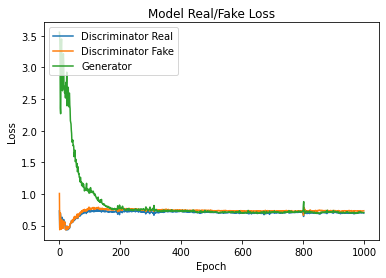

In [35]:
# plot Real/Fake loss
#plt.figure(figsize=(15, 15))
plt.plot(d_r_ep[:,1])
plt.plot(d_f_ep[:,1])
plt.plot(g_ep[:,1])
plt.title('Model Real/Fake Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator Real', 'Discriminator Fake', 'Generator'], loc='upper left')
plt.savefig("AC_GAN_real_fake_loss.png")
plt.show()

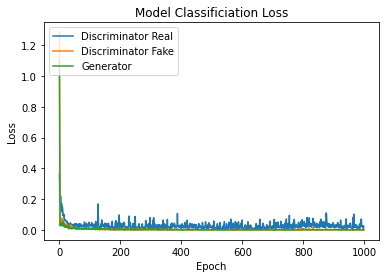

In [36]:
# plot Classification loss
#plt.figure(figsize=(15, 15))
plt.plot(d_r_ep[:,2])
plt.plot(d_f_ep[:,2])
plt.plot(g_ep[:,2])
plt.title('Model Classificiation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator Real', 'Discriminator Fake', 'Generator'], loc='upper left')
plt.savefig("AC_GAN_Classification_loss.png")
plt.show()

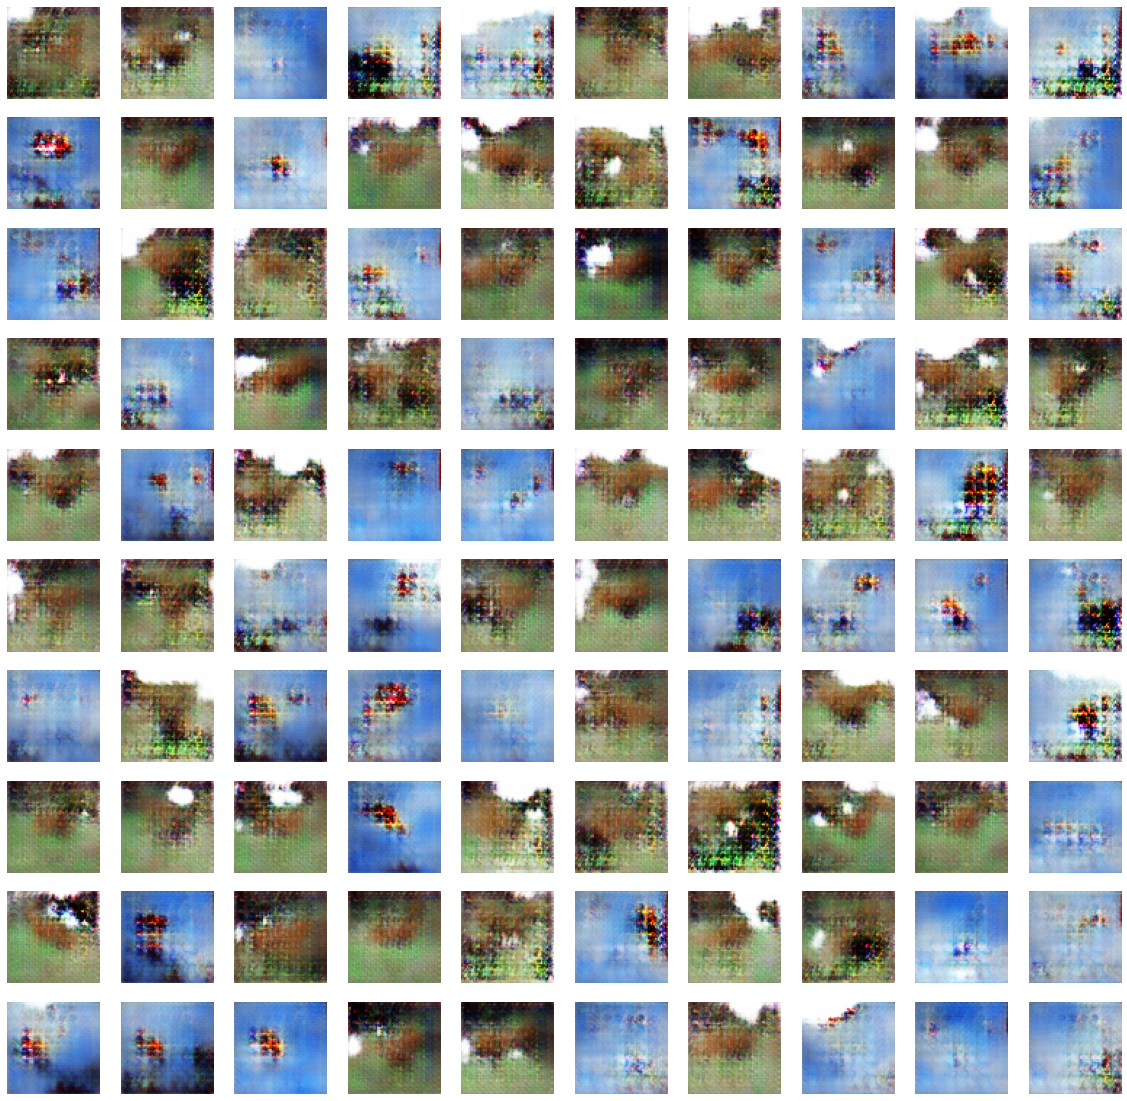

In [37]:
# Create 100 large images
latent_dim = 100
n_examples = 100
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_classes=NUM_CLASSES)
# generate images
X  = generator.predict([latent_points, labels]) # for AC-GAN
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, n_examples, file_name='10x10_final_images', fig_size=20)

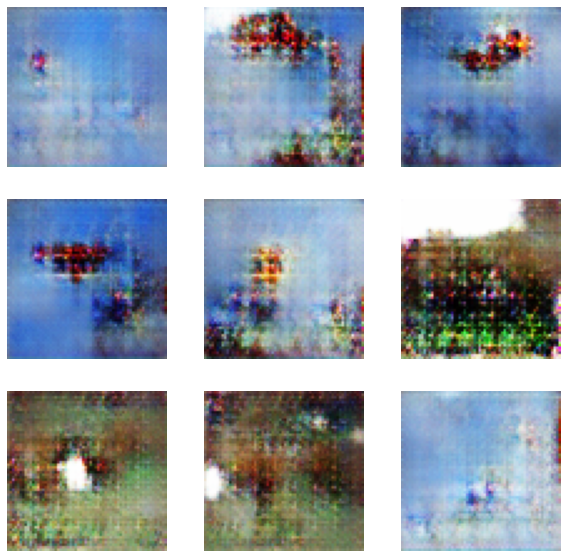

In [38]:
# Create 9 large images
latent_dim = 100
n_examples = 9
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_classes=NUM_CLASSES)
# generate images
X  = generator.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
save_plot(X, n_examples, file_name='3x3_final_images')

### Base GAN Analysis

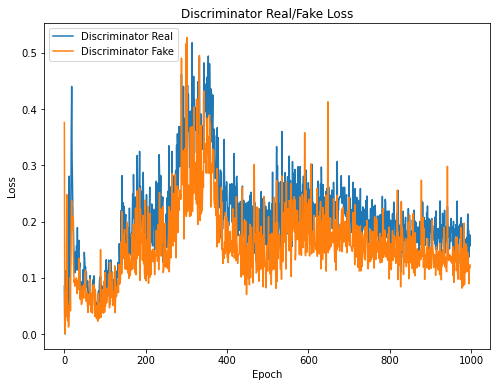

In [221]:
# plot real/fake for discriminator loss
plt.figure(figsize=(8,6))
plt.plot(d_r_ep[:])
plt.plot(d_f_ep[:])
#plt.plot(g_ep[:])
plt.title('Discriminator Real/Fake Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator Real', 'Discriminator Fake'], loc='upper left')
plt.savefig("Base_GAN_discriminator_loss.png")
plt.show()

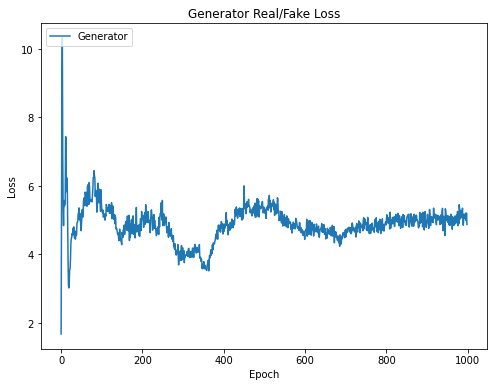

In [222]:
# plot real/fake for generator loss
plt.figure(figsize=(8,6))
plt.plot(g_ep[:])
plt.title('Generator Real/Fake Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Generator'], loc='upper left')
plt.savefig("Base_GAN_generator_loss.png")
plt.show()

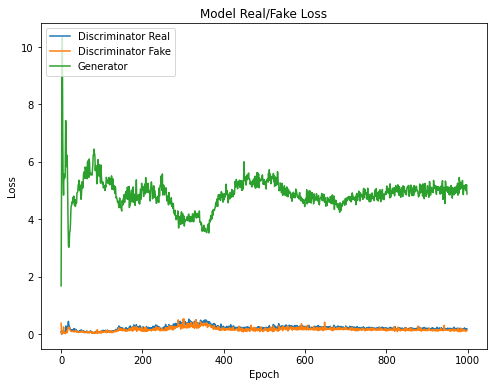

In [223]:
# plot real/fake for nonAC-GAN loss
plt.figure(figsize=(8,6))
plt.plot(d_r_ep[:])
plt.plot(d_f_ep[:])
plt.plot(g_ep[:])
plt.title('Model Real/Fake Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator Real', 'Discriminator Fake', 'Generator'], loc='upper left')
plt.savefig("Base_GAN_loss.png")
plt.show()

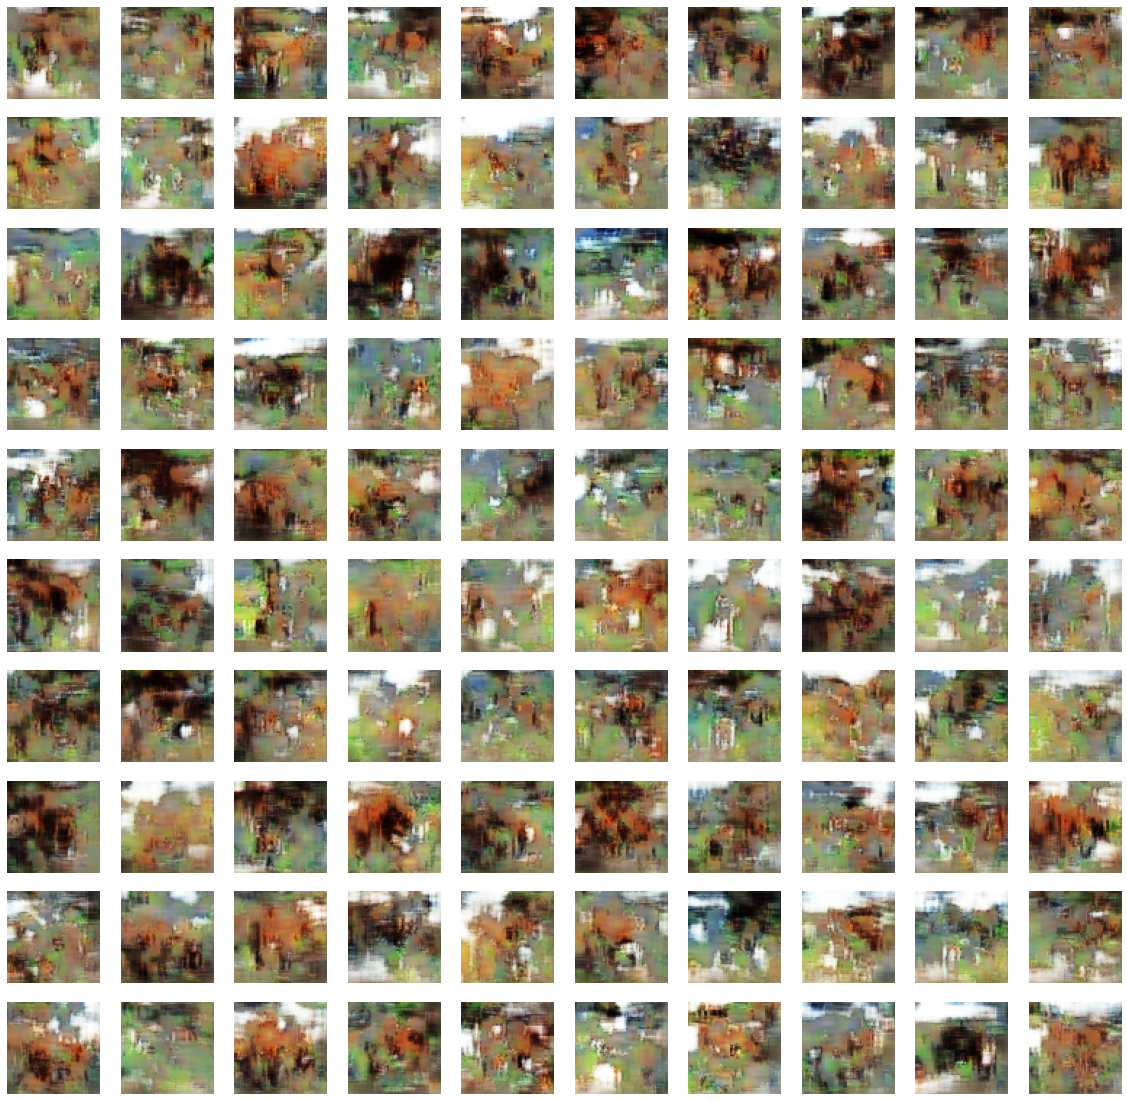

In [224]:
# create 100 images
latent_dim = 100
n_examples = 100 # must be a square
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_classes=1)
# generate images
X  = generator.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
save_plot(X, n_examples, file_name='10x10_final_images', fig_size=20)

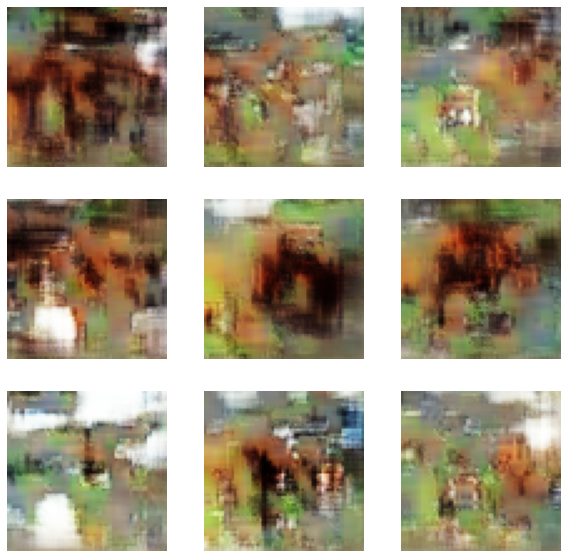

In [225]:
# create 9 large images
latent_dim = 100
n_examples = 9# must be a square
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_classes=1)
# generate images
X  = generator.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
save_plot(X, n_examples, file_name='3x3_final_images')

### Generate Directory and Save Results
- create a directory given the name at the start (stored in experiment_name)
- create new directories ... to store ...
    - ~/*/GAN/tests/%date_stamp%_test_name/models
        - .h5 model weight files
    - ~/*/GAN/tests/%date_stamp%_test_name/images
        - generated plots
        - model structures


In [228]:
# Create a directory to save generated model/images to
gan_test_directory = './gdrive/MyDrive/EEG2Image/GAN/tests/'
print("Contents of", gan_test_directory)
!ls $gan_test_directory

print("\nDirectory:", experiment_name, "will be generated at the end of successful training and result analysis")

month_day_year = str(dt.month) + '_' + str(dt.day) + '_' + str(dt.year)
print("\nDate stamp:", month_day_year)

if len(experiment_name) == 0 or experiment_name is None:
    print("Error in given name...\nSetting temporary directory name.")
    experiment_name = 'temp_name'

directory_name = month_day_year + '_' + experiment_name

full_path = gan_test_directory + directory_name + '/'
print("\nMaking a directory at", full_path)
!mkdir $full_path

print("\nContents of", gan_test_directory, "after attempting to generate directory")
!ls $gan_test_directory

print("\nContents of", full_path)
!ls $full_path

Contents of ./gdrive/MyDrive/EEG2Image/GAN/tests/
5_10_2021_1C_2x2_kernel_after_nearest_neighbor
5_10_2021_1C_5x5_kernel_after_nearest_neighbor
5_10_2021_1C_AC_GAN_architecture_with_NO_AC
5_10_2021_1C_DCGAN_3x3_NO_ReLU_BN_Dropout
5_10_2021_1C_DCGAN_3x3_YES_ReLU_BN_NO_Dropout_LR_0.0002_B1_0.5
5_10_2021_1C_DCGAN_3x3_YES_ReLU_NO_BN_Dropout
5_10_2021_1C_DCGAN_3x3_YES_ReLU_NO_BN_Dropout_LR_0.0002_B1_0.5
5_10_2021_1C_DCGAN_YES_ReLU_BN_Dropout
5_11_2021_1C_2x2_kernel_after_bilinear_interp
5_1_2021_AC_GAN_100_epo_test
5_1_2021_base_GAN_1_class_strided_conv
5_12_2021_1C_2x2_g_kernel_flipped_samples
5_12_2021_1C_3x3_kernel_after_nearest_neighbor
5_12_2021_1C_Base_D_SN_G
5_12_2021_1C_SN_D_Base_G
5_12_2021_1C_SN_G_and_D
5_14_2021_1C_SN_G_and_D_SAGAN_LR_and_BETA
5_3_2021_4x4_gen_all_128_channels
5_3_2021_4x4_gen_kernels_conv2dT
5_3_2021_4x4_lr_d_5e-5_lr_g_2e-4
5_5_2021_4x4_lr_d_lr_g_2e-4
5_5_2021_LR_D_1e-5_LR_G_2e-4
5_5_2021_LR_D_1e-5_LR_G_2e-4_start_ep1000
5_7_2021_2_c_Alex_model
5_7_2021_2_classe

In [229]:
print("Copying generated images to", full_path, "\n")
!cp ./*.png $full_path
print("Copying model artifacts to", full_path, "\n")
!cp ./*.h5 $full_path


print("\nContents of", full_path, "after copy attempt")
!ls $full_path

Copying generated images to ./gdrive/MyDrive/EEG2Image/GAN/tests/5_14_2021_1C_SAGAN/ 

Copying model artifacts to ./gdrive/MyDrive/EEG2Image/GAN/tests/5_14_2021_1C_SAGAN/ 


Contents of ./gdrive/MyDrive/EEG2Image/GAN/tests/5_14_2021_1C_SAGAN/ after copy attempt
10x10_final_images.png		 generated_plot_19600.png  model_16800.h5
3x3_final_images.png		 generated_plot_22400.png  model_19600.h5
Base_D_SN_G_GAN.png		 generated_plot_25200.png  model_22400.h5
Base_GAN_discriminator_loss.png  generated_plot_28000.png  model_25200.h5
Base_GAN_generator_loss.png	 generated_plot_2800.png   model_28000.h5
Base_GAN_loss.png		 generated_plot_5600.png   model_2800.h5
discriminator.png		 generated_plot_8400.png   model_5600.h5
generated_plot_11200.png	 generator.png		   model_8400.h5
generated_plot_14000.png	 model_11200.h5
generated_plot_16800.png	 model_14000.h5


In [230]:
# Create log file for hyperparameters # not done yet
'''
log_file = 'Test_Summary.txt'
contents = []
summary = "Testing the log file"
contents.append("")
'''

'\nlog_file = \'Test_Summary.txt\'\ncontents = []\nsummary = "Testing the log file"\ncontents.append("")\n'

In [231]:
# save hyper parameters
'''
log_file = 'hyper_parameters.txt'
params = []
params.append('Latent Dimension: '  + str(latent_dim))
params.append('Discriminator Learning Rate: ' + str(LR_D))
params.append('Generator Learning Rate: ' + str(LR_G))
params.append('Discriminator BETA 1: ' + str(BETA_1_D))
params.append('Generator BETA 1: ' + str(BETA_1_G))
params.append('Epochs: ' + str(NUM_EPOCHS))

for param in params:
    print(param)
    !printf $param + "\n" >> $log_file
'''

'\nlog_file = \'hyper_parameters.txt\'\nparams = []\nparams.append(\'Latent Dimension: \'  + str(latent_dim))\nparams.append(\'Discriminator Learning Rate: \' + str(LR_D))\nparams.append(\'Generator Learning Rate: \' + str(LR_G))\nparams.append(\'Discriminator BETA 1: \' + str(BETA_1_D))\nparams.append(\'Generator BETA 1: \' + str(BETA_1_G))\nparams.append(\'Epochs: \' + str(NUM_EPOCHS))\n\nfor param in params:\n    print(param)\n    !printf $param + "\n" >> $log_file\n'

In [232]:
# clean the current directory
print("Cleaning current working directory")
!rm ./*.png
!rm ./*.h5

Cleaning current working directory


### Load Saved Model

In [25]:
# load the saved model and make images 
!cp ./gdrive/MyDrive/EEG2Image/GAN/tests/5_5_2021_LR_D_1e-5_LR_G_2e-4/generator_9000.h5 ./
!cp ./gdrive/MyDrive/EEG2Image/GAN/tests/5_5_2021_LR_D_1e-5_LR_G_2e-4/discriminator_9000.h5 ./
!cp ./gdrive/MyDrive/EEG2Image/GAN/tests/5_5_2021_LR_D_1e-5_LR_G_2e-4/gan_9000.h5 ./

In [23]:
from tensorflow.keras.models import load_model
def load():
    discriminator = load_model('discriminator_9000.h5')
    generator = load_model('generator_9000.h5')
    gan = load_model('gan_9000.h5')
    gan.summary()
    discriminator.summary()
    generator.summary()

    return gan, generator, discriminator

In [26]:
gan_model, generator, discriminator = load()

Model: "Combined_AC_GAN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_64 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_63 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_93 (Dense)                (None, 8192)         827392      input_64[0][0]                   
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 1, 50)        50          input_63[0][0]                   
____________________________________________________________________________________

## Spectral Normalization GAN
- run code cells in AC-GAN for helper functions
- only define generator, discriminator and GAN here

In [17]:
!pip install tensorflow_addons

     |████████████████████████████████| 706kB 8.6MB/s 


In [18]:
# use TFA spectral norm
import tensorflow_addons as tfa
from tensorflow_addons.layers import SpectralNormalization

In [28]:
# working up from just conv - using spectral normalization
def define_discriminator_SNGAN(in_shape=(64,64,3), lr=0.0002, beta_1=0.5, beta_2=0.999):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=in_shape)
	# downsample to 32x32
	fe = SpectralNormalization(Conv2D(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init))(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample to 16x16
	fe = SpectralNormalization(Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init))(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample to 8x8
	fe = SpectralNormalization(Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init))(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# real/fake output
	out1 = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model(in_image, out1, name='SN-Discriminator_3x3_kernel')
	# compile model
	opt = Adam(lr=lr, beta_1=beta_1, beta_2=beta_2)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [29]:
# 3x3 - working up from just conv - using spectral normalization
def define_generator_SNGAN(latent_dim=100):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image generator input
    in_lat = Input(shape=(latent_dim,))

    # foundation for 8x8 image
    n_nodes = 128 * 8 * 8
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((8, 8, 128))(gen)

    # upsample to 16x16
    gen = UpSampling2D(size=(2,2), interpolation='nearest')(gen)
    gen = SpectralNormalization(Conv2D(32, (2,2), padding='same', kernel_initializer=init))(gen)
    gen = Activation('relu')(gen)

    # upsample to 32x32
    gen = UpSampling2D(size=(2,2), interpolation='nearest')(gen)
    gen = SpectralNormalization(Conv2D(32, (2,2), padding='same', kernel_initializer=init))(gen)
    gen = Activation('relu')(gen)

    # upsample to 64x64
    gen = UpSampling2D(size=(2,2), interpolation='nearest')(gen)
    gen = SpectralNormalization(Conv2D(3, (2,2), padding='same', kernel_initializer=init))(gen)
    out_layer = Activation('tanh')(gen)
    
    # define model
    model = Model(in_lat, out_layer, name='SN-Generator_2x2_kernel')
    return model

In [209]:
max_tokens = 32
dim = 4 # channels/k where k = 8: from SA-GAN paper

# SN with self attention layer
def define_generator_SAGAN_debug(latent_dim=100):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image generator input
    in_lat = Input(shape=(latent_dim,))

    # foundation for 8x8 image
    n_nodes = 128 * 8 * 8
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((8, 8, 128))(gen)

    # upsample to 16x16
    gen = UpSampling2D(size=(2,2), interpolation='nearest')(gen)
    gen = SpectralNormalization(Conv2D(32, (2,2), padding='same', kernel_initializer=init))(gen)
    gen = Activation('relu')(gen)

    # upsample to 32x32
    gen = UpSampling2D(size=(2,2), interpolation='nearest')(gen)
    gen = SpectralNormalization(Conv2D(32, (2,2), padding='same', kernel_initializer=init))(gen)
    gen = Activation('relu')(gen)

    # self attention layer
    print("Input shape at SA layer:", gen.shape)

    # f = Query
    f = Conv2D(dim, (1,1), kernel_initializer=init)(gen)
    print("Shape of the query after 1x1:", f.shape)
    f = K.permute_dimensions(f, (0, 2, 1, 3))
    print("Shape of the query after transpose:", f.shape)
    # flatten
    #f = Flatten()(f)
    f = Reshape(target_shape=(dim, 32*32))(f)
    print("Shape of the query after flatten", f.shape)

    # g = Key
    g = Conv2D(dim, (1,1), kernel_initializer=init)(gen)
    print("Shape of the key after 1x1", g.shape)
    # flatten the 32x32
    g = Reshape(target_shape=(32*32, dim))(g)
    #g = Reshape(target_shape=(g.shape[0], -1, g.shape[-1]))(g)
    #g = tf.reshape(g, shape=[g.shape[0], -1, g.shape[-1]])
    print("Shape of the key after flatten", g.shape)

    # a = attention before softmax
    a = tf.matmul(g,f)
    print("Shape of the matrix multiplication: key x query (should this be query x key?):", a.shape)

    # a_map = attention map
    a_map = Softmax()(a)
    print("Shape of attention map after softmax:", a_map.shape)
    #a_map = Reshape(target_shape=())(a_map)

    # h = Value
    h = Conv2D(dim, (1,1), kernel_initializer=init)(gen)
    print("Shape of the value after 1x1", h.shape)
    h = Reshape(target_shape=(dim, 32*32))(h)
    print("Shape of the value after flatten", h.shape)

    # o = output
    a_map = K.permute_dimensions(a_map, (0, 2, 1))
    print("Shape after transposing the attention map:", a_map.shape)

    o = tf.matmul(h, a_map)
    print("Shape of o = h x attention map:", o.shape)
    o = Reshape(target_shape=(32, 32, dim))(o)
    print("Shape of o after converting back to 32x32:", o.shape)
    # apply another convolution to attention map x h
    o = Conv2D(32, (1,1), kernel_initializer=init)(o)
    print("Shape of o after 1x1:", o.shape)

    # gen was original input
    gamma = tf.Variable(initial_value=0, dtype=tf.float32)
    self_attention = gamma * o + gen # adding back the input feature map to learned scale of self attention module
    print("Shape of self attention layer:", self_attention.shape)

    # upsample to 64x64
    gen = UpSampling2D(size=(2,2), interpolation='nearest')(self_attention)
    gen = SpectralNormalization(Conv2D(3, (2,2), padding='same', kernel_initializer=init))(gen)
    out_layer = Activation('tanh')(gen)
    
    # define model
    model = Model(in_lat, out_layer, name='SAGAN-Generator_dim_4')
    return model

In [233]:
max_tokens = 32
dim = 4 # channels/k where k = 8: from SA-GAN paper

# SN with self attention layer
def define_generator_SAGAN(latent_dim=100):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image generator input
    in_lat = Input(shape=(latent_dim,))

    # foundation for 8x8 image
    n_nodes = 128 * 8 * 8
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((8, 8, 128))(gen)

    # upsample to 16x16
    gen = UpSampling2D(size=(2,2), interpolation='nearest')(gen)
    gen = SpectralNormalization(Conv2D(32, (2,2), padding='same', kernel_initializer=init))(gen)
    gen = Activation('relu')(gen)

    # upsample to 32x32
    gen = UpSampling2D(size=(2,2), interpolation='nearest')(gen)
    gen = SpectralNormalization(Conv2D(32, (2,2), padding='same', kernel_initializer=init))(gen)
    gen = Activation('relu')(gen)

    # self attention layer
    # f = Query
    f = Conv2D(dim, (1,1), kernel_initializer=init)(gen)
    f = K.permute_dimensions(f, (0, 2, 1, 3))
    # flatten
    #f = Flatten()(f)
    f = Reshape(target_shape=(dim, 32*32))(f)

    # g = Key
    g = Conv2D(dim, (1,1), kernel_initializer=init)(gen)
    # flatten the 32x32
    g = Reshape(target_shape=(32*32, dim))(g)

    # a = attention before softmax
    a = tf.matmul(g,f)
    # a_map = attention map
    a_map = Softmax()(a)
    #a_map = Reshape(target_shape=())(a_map)

    # h = Value
    h = Conv2D(dim, (1,1), kernel_initializer=init)(gen)
    h = Reshape(target_shape=(dim, 32*32))(h)

    # o = output
    a_map = K.permute_dimensions(a_map, (0, 2, 1))
    o = tf.matmul(h, a_map)
    o = Reshape(target_shape=(32, 32, dim))(o)
    # apply another convolution to attention map x h
    o = Conv2D(32, (1,1), kernel_initializer=init)(o)
    # gen was original input
    gamma = tf.Variable(initial_value=0.5, dtype=tf.float32)
    self_attention = gamma * o + gen # adding back the input feature map to learned scale of self attention module

    # upsample to 64x64
    gen = UpSampling2D(size=(2,2), interpolation='nearest')(self_attention)
    gen = SpectralNormalization(Conv2D(3, (2,2), padding='same', kernel_initializer=init))(gen)
    out_layer = Activation('tanh')(gen)
    
    # define model
    model = Model(in_lat, out_layer, name='SAGAN-Generator_dim_4')
    return model

In [211]:
g = define_generator_SAGAN_debug()
#d = define_discriminator_SNGAN()

Input shape at SA layer: (None, 32, 32, 32)
Shape of the query after 1x1: (None, 32, 32, 4)
Shape of the query after transpose: (None, 32, 32, 4)
Shape of the query after flatten (None, 4, 1024)
Shape of the key after 1x1 (None, 32, 32, 4)
Shape of the key after flatten (None, 1024, 4)
Shape of the matrix multiplication: key x query (should this be query x key?): (None, 1024, 1024)
Shape of attention map after softmax: (None, 1024, 1024)
Shape of the value after 1x1 (None, 32, 32, 4)
Shape of the value after flatten (None, 4, 1024)
Shape after transposing the attention map: (None, 1024, 1024)
Shape of o = h x attention map: (None, 4, 1024)
Shape of o after converting back to 32x32: (None, 32, 32, 4)
Shape of o after 1x1: (None, 32, 32, 32)
Shape of self attention layer: (None, 32, 32, 32)


In [212]:
g.summary()

Model: "SAGAN-Generator_dim_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_67 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense_66 (Dense)                (None, 8192)         827392      input_67[0][0]                   
__________________________________________________________________________________________________
activation_224 (Activation)     (None, 8192)         0           dense_66[0][0]                   
__________________________________________________________________________________________________
reshape_174 (Reshape)           (None, 8, 8, 128)    0           activation_224[0][0]             
______________________________________________________________________________

In [157]:
d.summary()

Model: "SN-Discriminator_3x3_kernel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
spectral_normalization_35 (S (None, 32, 32, 64)        1856      
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
spectral_normalization_36 (S (None, 16, 16, 128)       73984     
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
spectral_normalization_37 (S (None, 8, 8, 256)         295424    
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 8, 